In [1]:
import copy
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
from matplotlib import pyplot as plt

class ImgaugAugmentor:
    def __init__(self, cfg, **kwargs):
        self.cfg = cfg

        ia.seed(666)
        self.ia = ia
        self.iaa = iaa

        # 随机通道处理,加减100以内
        self.aug_WithChannels = iaa.WithChannels((0, 2), iaa.Add((-100, 100)))
        # 随机裁剪和填充，percent为裁剪与填充比例，负数为放大后裁剪，正数为缩小和填充，pad_mode为填充方式，pad_cval为当空白填充时，填充像素值
        self.aug_CropAndPad = iaa.CropAndPad(percent=(-0.05, 0.1), pad_mode=ia.ALL, pad_cval=(0, 255))
        # 随机水平翻转,参数为概率
        self.aug_Fliplr = iaa.Fliplr(0.5)
        # 随机垂直翻转,参数为概率
        self.aug_Flipud = iaa.Flipud(0.5)
        # 超像素表示,p_replace被超像素代替的百分比,n_segments分割块数
        self.aug_Superpixels = iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))
        # 灰度化 (0.0,1.0),前者为偏彩色部分，后者为偏灰度部分，随机灰度化
        self.aug_GrayScale = iaa.Grayscale(alpha=(0.0, 0.6))
        # 高斯模糊
        self.aug_GaussianBlur = iaa.GaussianBlur(sigma=(0, 1.4))
        # 均值模糊，k为kernel size
        self.aug_AverageBlur = iaa.AverageBlur(k=(2, 7))
        # 中值模糊, k为kernel size
        self.aug_MedianBlur = iaa.MedianBlur(k=(3, 11))
        # 双边滤波,d为kernel size,sigma_color为颜色域标准差,sigma_space为空间域标准差
        self.aug_BilateralBlur = iaa.BilateralBlur(sigma_color=(10, 250), sigma_space=(10, 250), d=(3, 7))
        # 锐化
        self.aug_Sharpen = iaa.Sharpen(alpha=(0.0, 0.06), lightness=(0.95, 1.05))
        # 浮雕效果
        self.aug_Emboss = iaa.Emboss(alpha=(0.0, 1.0), strength=(0.0, 1.5))
        # 边缘检测
        self.aug_EdgeDetect = iaa.EdgeDetect(alpha=(0.0, 1.0))
        # 方向性边缘检测
        self.aug_DirectedEdgeDetece = iaa.DirectedEdgeDetect(alpha=(0.0, 1.0), direction=(0.0, 1.0))
        # 暴力叠加像素值,每个像素统一加一个值
        self.aug_Add = iaa.Add((-40, 40))
        # 暴力叠加像素值，每个像素加不同的值
        self.aug_AddElementwise = iaa.AddElementwise((-40, 40))
        # 随机高斯加性噪声
        self.aug_AdditiveGaussianNoise = iaa.AdditiveGaussianNoise(scale=(0.0, 0.1 * 255))
        # 暴力乘法,每个像素统一乘以一个值
        self.aug_Multiply = iaa.Multiply((0.8, 1.2))
        # 暴力乘法,每个像素乘以不同值
        self.aug_MultiplyElementwise = iaa.MultiplyElementwise((0.8, 1.2))
        # 随机dropout像素值
        self.aug_Dropout = iaa.Dropout(p=(0, 0.2))
        # 随机粗dropout,2*2方块像素被dropout
        self.aug_CoarseDropout = iaa.CoarseDropout(0.02, size_percent=0.5)
        # 50%的图片,p概率反转颜色
        self.aug_Invert = iaa.Invert(0.25, per_channel=0.5)
        # 对比度归一化
        self.aug_ContrastNormalization = iaa.ContrastNormalization((0.8, 1.2))
        # 仿射变换
        self.aug_Affine = iaa.Affine(rotate=(-2, 2), scale={"x": (0.99, 1.01), "y": (0.99, 1.01)},
                                     translate_px={"x": (-3, 3), "y": (-3, 3)})  # "x": (0.8, 1.2), "y": (0.8, 1.2)
        # 仿射变换, 局部像素仿射扭曲
        self.aug_PiecewiseAffine = iaa.PiecewiseAffine(scale=(0.01, 0.05))
        # 单应性变换
        self.aug_PerspectiveTransform = iaa.PerspectiveTransform(scale=(0.01, 0.1))  # scale=(0.01, 0.1
        # 弹性变换
        self.aug_ElasticTransformation = iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25)
        # 简单的加噪,小黑块
        self.aug_SimplexNoiseAlpha = iaa.SimplexNoiseAlpha(iaa.OneOf(
            [iaa.EdgeDetect(alpha=(0.0, 0.5)), iaa.DirectedEdgeDetect(alpha=(0.0, 0.5), direction=(0.0, 1.0)), ]))
        # 频域加噪，表现为色彩的块状变换
        self.aug_FrequencyNoiseAlpha = iaa.FrequencyNoiseAlpha(exponent=(-4, 0),
                                                               first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                                               second=iaa.ContrastNormalization((0.5, 2.0)))
        #
        self.aug_AdditiveLaplaceNoise = iaa.AdditiveLaplaceNoise(scale=(0.0, 0.1 * 255))
        #
        self.aug_AdditivePoissonNoise = iaa.AdditivePoissonNoise(lam=(0.0, 3.0))
        #
        self.aug_Salt = iaa.Salt(p=(0, 0.03))
        #
        self.aug_Pepper = iaa.Pepper(p=(0, 0.03))
        #
        self.aug_SaltAndPepper = iaa.SaltAndPepper(p=(0, 0.03))
        #
        self.aug_JpegCompression = iaa.JpegCompression(compression=(80, 100))
        #
        self.aug_MotionBlur = iaa.MotionBlur(k=(3, 5), angle=(0, 360), direction=(-1.0, 1.0), order=1)
        #
        self.aug_GammaContrast = iaa.GammaContrast(gamma=(0.95, 1.05), per_channel=False)
        #
        self.aug_SigmoidContrast = iaa.SigmoidContrast(gain=(1, 5), cutoff=(0.0, 0.25), per_channel=False)
        #
        self.aug_LogContrast = iaa.LogContrast(gain=(1, 5), per_channel=False)
        #
        self.aug_LinearContrast = iaa.LinearContrast(alpha=(0.98, 1.03), per_channel=False)
        #
        self.aug_FastSnowyLandscape = iaa.FastSnowyLandscape(lightness_threshold=(100, 255),
                                                             lightness_multiplier=(1.0, 4.0))
        #
        self.aug_Clouds = iaa.Clouds()
        #
        self.aug_Fog = iaa.Fog()
        #
        self.aug_Snowflakes = iaa.Snowflakes(density=(0.005, 0.075), density_uniformity=(0.3, 0.9),
                                             flake_size=(0.2, 0.7), flake_size_uniformity=(0.4, 0.8), angle=(-30, 30),
                                             speed=(0.007, 0.03))

        # all
        self.aug_all = [self.aug_WithChannels, self.aug_CropAndPad, self.aug_Fliplr, self.aug_Flipud, self.aug_Superpixels, self.aug_GrayScale,
                        self.aug_GaussianBlur, self.aug_AverageBlur, self.aug_MedianBlur, self.aug_BilateralBlur, self.aug_Sharpen, self.aug_Emboss,
                        self.aug_EdgeDetect, self.aug_DirectedEdgeDetece, self.aug_Add, self.aug_AddElementwise, self.aug_AdditiveGaussianNoise,
                        self.aug_Multiply, self.aug_MultiplyElementwise, self.aug_Dropout, self.aug_CoarseDropout, self.aug_Invert,
                        self.aug_ContrastNormalization, self.aug_Affine, self.aug_PiecewiseAffine, self.aug_PerspectiveTransform,
                        self.aug_ElasticTransformation, self.aug_SimplexNoiseAlpha, self.aug_FrequencyNoiseAlpha, self.aug_AdditiveLaplaceNoise,
                        self.aug_AdditivePoissonNoise, self.aug_Salt, self.aug_Pepper, self.aug_SaltAndPepper, self.aug_JpegCompression,
                        self.aug_MotionBlur, self.aug_GammaContrast, self.aug_SigmoidContrast, self.aug_LogContrast, self.aug_LinearContrast,
                        self.aug_FastSnowyLandscape, self.aug_Clouds, self.aug_Fog, self.aug_Snowflakes]

    def _example(self, image, **kwargs):
        """
        示例函数, 用于示例
        :param image:
        :param kwargs:
        :return:
        """
        method_list = [self.aug_Fliplr,self.aug_Flipud] # 随机上下，左右翻转
        # 随机采用method里的0-method_num种方法
        method_num = 2
        seq = iaa.Sometimes(p=1, then_list=iaa.SomeOf((0,method_num), method_list))
        out_image = seq(images=image) if image.ndim == 4 else seq(image=image)
        return out_image


    def aug_image(self, image, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_basics.html
        :param image:
        :param kwargs:
        :return:
        """
        method_list = kwargs.get("method_list", self.aug_all)
        # 随机采用method里的0-method_num种方法
        method_num = 2
        seq = iaa.Sometimes(p=1, then_list=iaa.SomeOf((0,method_num), method_list))
        out_image = seq(images=image) if image.ndim == 4 else seq(image=image)
        return out_image


    def aug_image_and_bbox(self, image, dets, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_bounding_boxes.html
        dets: x1, y1, x2, y2, cls
        :param image:
        :param kwargs:
        :return:
        """
        method_list = kwargs.get("method_list", self.aug_all)
        # bbox
        before_aug_boxes = []
        before_aug_label = []
        for det in dets:
            x1, y1, x2, y2, label = det
            before_aug_boxes.append(ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2))
            before_aug_label.append(label)

        bbs = ia.BoundingBoxesOnImage(before_aug_boxes, shape=image.shape)

        # 随机采用method里的0-method_num种方法
        method_num = 2
        seq = iaa.Sometimes(p=1, then_list=iaa.SomeOf((0,method_num), method_list))
        out_image, bbs_aug = seq(image=image.astype(np.uint8),  bounding_boxes=bbs)

        out_dets = []
        for bb, ll in zip(bbs_aug.bounding_boxes, before_aug_label):
            if bb.is_fully_within_image(out_image.shape):
                out_dets.append([bb.x1, bb.y1, bb.x2, bb.y2, ll])
            elif bb.is_partly_within_image(out_image.shape):
                x1 = max(0, min(out_image.shape[1], bb.x1))
                y1 = max(0, min(out_image.shape[0], bb.y1))
                x2 = max(0, min(out_image.shape[1], bb.x2))
                y2 = max(0, min(out_image.shape[0], bb.y2))
                out_dets.append([x1, y1, x2, y2, ll])
            else:
                continue
        # if augmentataion failed
        if len(dets) != 0 and  len(out_dets) == 0:
            out_image = image.copy()
            out_dets = dets.copy()

        return out_image, out_dets


    def aug_image_and_mask(self, image, segmap, num_classes, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html
        nb_classes: [background_class_id] 1+ num_classes
        :param image: 
        :param segmap: 
        :param num_classes: 
        :param kwargs: 
        :return: 
        """
        method_list = kwargs.get("method_list", self.aug_all)
        seg_map = ia.SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=1 + num_classes)

        method_num = 2
        seq = iaa.Sometimes(p=1, then_list=iaa.SomeOf((0, method_num), method_list))
        out_image, segmap_aug = seq(image=image.astype(np.uint8), segmentation_maps=seg_map)

        return out_image, segmap_aug


    def aug_image_and_keypoint(self, image, keypoints, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html
        :param image: 
        :param keypoints: 
        :param kwargs: 
        :return: 
        """
        method_list = kwargs.get("method_list", self.aug_all)
        # kps
        before_aug_keypoint = []
        for keypoint in keypoints:
            x, y = keypoint
            before_aug_keypoint.append(ia.Keypoint(x=x, y=y))

        kps = ia.KeypointsOnImage(before_aug_keypoint, shape=image.shape)

        # 随机采用method里的0-method_num种
        method_num = 2
        seq = iaa.Sometimes(p=1, then_list=iaa.SomeOf((0, method_num), method_list))
        out_image, kps_aug = seq(image=image.astype(np.uint8), keypoints=kps)

        out_kps = []
        for kp in kps_aug.keypoints:
            x, y = kp.x, kp.y
            if x >= 0 and x < image.shape[1] and y >= 0 and y < image.shape[0]:
                out_kps.append([x, y])
        # if augmentataion failed
        if len(keypoints) != 0 and len(out_kps) == 0:
            out_image = image.copy()
            out_kps = keypoints.copy()

        return out_image, out_kps


    def aug_image_and_heapmap(self, image, heapmap, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_heatmaps.html
        :param image: 
        :param heapmaps: 
        :param kwargs: 
        :return: 
        """
        print("Heatmap support is currently in a Beta phase. Unittests are not yet finished.")
        method_list = kwargs.get("method_list", self.aug_all)

        heap_map = ia.HeatmapsOnImage(heapmap, shape=image.shape)
        method_num = 2
        seq = iaa.Sometimes(p=1, then_list=iaa.SomeOf((0, method_num), method_list))
        out_image, heapmap_aug = seq(image=image.astype(np.uint8), heatmaps=heap_map)
        return out_image, heapmap_aug
imgaugAugmentor = ImgaugAugmentor(None)

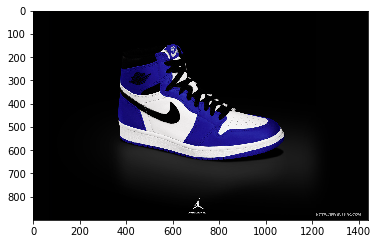

In [2]:
org_image = cv2.imread("../data/01.jpg")
plt.imshow(org_image)

image augmentation is done!


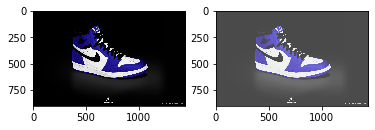

In [8]:
# image
aug_img = imgaugAugmentor.aug_image(org_image)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(org_image)
plt.subplot(1,2,2)
plt.imshow(aug_img)
print("image augmentation is done!")

BB 0: (65.0000, 100.0000, 200.0000, 150.0000) -> (61.0089, 95.1932, 196.5254, 146.0995)
BB 1: (150.0000, 80.0000, 200.0000, 130.0000) -> (146.3193, 74.9892, 196.5397, 125.6482)
image and bounding boxes augmentation is done!


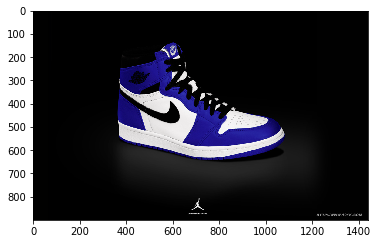

In [8]:
# bbox
dets = [[65, 100, 200, 150, 1], [150, 80, 200, 130, 0]]
aug_img, aug_dets = imgaugAugmentor.aug_image_and_bbox(org_image, dets, method_list=[imgaugAugmentor.aug_PerspectiveTransform])
plt.imshow(aug_img)
for i, (before, after) in enumerate(zip(dets, aug_dets)):
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (i,
                                                                           before[0], before[1], before[2],
                                                                           before[3],
                                                                           after[0], after[1], after[2],
                                                                           after[3]))
print("image and bounding boxes augmentation is done!")

image and segmentation maps(masks) augmentation is done!


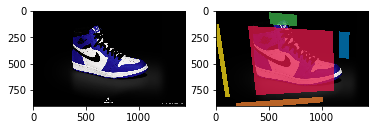

In [10]:
# mask
segmap = np.zeros((org_image.shape[0], org_image.shape[1]), dtype=np.int32)
segmap[200:700, 350:1000] = 1
segmap[100:180, 500:700] = 2
segmap[200:700, 140:170] = 3
segmap[200:420, 1050:1150] = 4
segmap[750:800, 200:900] = 5

aug_img, aug_segmaps = imgaugAugmentor.aug_image_and_mask(org_image, segmap, 5,
                                                      method_list=[imgaugAugmentor.aug_PerspectiveTransform])
draw = aug_segmaps.draw_on_image(aug_img)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(org_image)
plt.subplot(1,2,2)
plt.imshow(draw)
print("image and segmentation maps(masks) augmentation is done!")


Keypoint 0: (65.00000000, 100.00000000) -> (43.29885101, 69.02378082)
Keypoint 1: (75.00000000, 200.00000000) -> (49.81835175, 170.08851624)
Keypoint 2: (100.00000000, 100.00000000) -> (77.95314026, 68.79620361)
Keypoint 3: (200.00000000, 80.00000000) -> (177.94462585, 47.95215988)
image and keypoints augmentation is done!


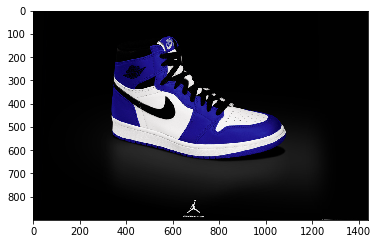

In [46]:
# keypoint
kps = [[65, 100], [75, 200], [100, 100], [200, 80]]
aug_img, aug_kps = imgaugAugmentor.aug_image_and_keypoint(org_image, kps,
                                                          method_list=[imgaugAugmentor.aug_PerspectiveTransform])
plt.imshow(aug_img)
for i, (before, after) in enumerate(zip(kps, aug_kps)):
    print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
        i, before[0], before[1], after[0], after[1]))
print("image and keypoints augmentation is done!")


Heatmap support is currently in a Beta phase. Unittests are not yet finished.
image and heapmaps augmentation is done!


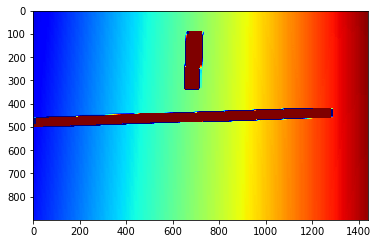

In [51]:
# heapmap
depth = np.linspace(0, 1, 256).astype(np.float32)
depth = np.tile(depth.reshape(1, 256), (256, 1))
depth[128 - 4:128 + 4, 32:256 - 32] = 0.75 * 100.0  # line from left to right
depth[32:128 - 32, 128 - 4:128 + 4] = 1.0 * 100.0  # line from top to bottom

aug_img, aug_heapmaps = imgaugAugmentor.aug_image_and_heapmap(org_image, depth,
                                                          method_list=[imgaugAugmentor.aug_PerspectiveTransform])
draw = aug_heapmaps.draw(size=org_image.shape[:2])[0]
plt.imshow(draw)
print("image and heapmaps augmentation is done!")